In [1]:
import numpy as np
import keras
import os
from pathlib import Path

In [2]:
batch_size = 32
epochs = 100
latent_dim = 512
num_samples = 2000
data_path = 'D:\Translator seq2seq\hin.txt'

In [14]:
input = ""
target = ""

In [15]:
input_texts = []
target_texts = []
input_char = set()
target_char = set()
with open(data_path,'r',encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text,target_text,_ = line.split('\t')
    target_text = "\t" + target_text + "\n"
    input += input_text
    target += target_text
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_char:
            input_char.add(char)
    for char in target_text:
        if char not in target_char:
            target_char.add(char) 

input_char = sorted(list(input_char))
target_char = sorted(list(target_char))
num_encoder_tokens = len(input_char)
num_decoder_tokens = len(target_char)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)                   

input_token_index = dict([(char,i) for i,char in enumerate(input_char)])
target_token_index = dict([(char,i) for i,char in enumerate(target_char)])

encoder_input_data = np.zeros((len(input_texts),max_encoder_seq_length,num_encoder_tokens),dtype = 'float32')
decoder_input_data = np.zeros((len(input_texts),max_decoder_seq_length,num_decoder_tokens),dtype = 'float32')
decoder_target_data = np.zeros((len(input_texts),max_decoder_seq_length,num_decoder_tokens),dtype = 'float32')

for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]] = 1.0
    encoder_input_data[i,t+1:,input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0    


Number of samples: 2000
Number of unique input tokens: 69
Number of unique output tokens: 89
Max sequence length for inputs: 34
Max sequence length for outputs: 62


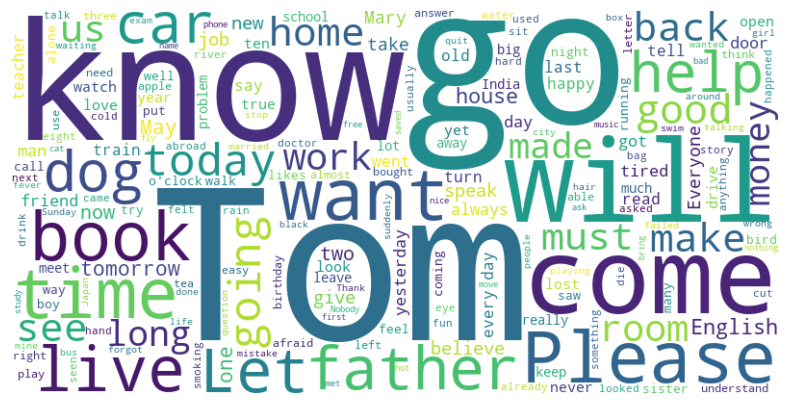

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(input)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [4]:
encoder_inputs = keras.Input(shape=(None,num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim,return_state=True)
encoder_outputs,state_h,state_c = encoder(encoder_inputs)

encoder_states = [state_h,state_c]
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))


decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [5]:
model.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.fit([encoder_input_data,decoder_input_data],decoder_target_data,epochs=100,batch_size=batch_size,validation_split=0.2)
model.save("s2s_model.keras")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - accuracy: 0.5990 - loss: 2.3974 - val_accuracy: 0.5587 - val_loss: 1.9960
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - accuracy: 0.6673 - loss: 1.4410 - val_accuracy: 0.5596 - val_loss: 1.7875
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - accuracy: 0.6697 - loss: 1.3502 - val_accuracy: 0.5649 - val_loss: 1.7533
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.6792 - loss: 1.2765 - val_accuracy: 0.5988 - val_loss: 1.6170
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - accuracy: 0.7110 - loss: 1.1466 - val_accuracy: 0.6350 - val_loss: 1.4354
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 445ms/step - accuracy: 0.7336 - loss: 1.0367 - val_accuracy: 0.6519 - val_loss: 1.3423
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.7526 - loss: 0.9543 - val_accuracy: 0.6675 - val_loss: 1.2735
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 507ms/step - accuracy: 0.7339 - loss: 1.1733 - 

In [6]:
model = keras.models.load_model("s2s_model.keras")

encoder_inputs = model.input[0]
encoder_outputs,state_h_enc,state_c_enc = model.layers[2].output
encoder_states = [state_h_enc,state_c_enc]
encoder_model = keras.Model(encoder_inputs,encoder_states)

decoder_inputs = model.input[1]  
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)


reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq, verbose=0)

    
    target_seq = np.zeros((1, 1, num_decoder_tokens))
   
    target_seq[0, 0, target_token_index["\t"]] = 1.0

   
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

       
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

      
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

     
        states_value = [h, c]
    return decoded_sentence


In [8]:
for seq_index in range(200):
    
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)
